In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from keras import Model
from tensorflow.keras.optimizers import Adam
# System libraries
from pathlib import Path
import os.path
# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [45]:
#check dataset
import os
import PIL
from PIL import Image
from pathlib import Path
from PIL import UnidentifiedImageError
dataset = "/home/bkcs/NIMA/dataset/Medium/"
#path = Path(dataset).rglob("*.jpg")
for img_p in os.listdir(dataset):
    try:
        #print(img_p)
        img = Image.open(os.path.join(dataset, img_p))
        img.verify()
    except PIL.UnidentifiedImageError:
        print(img_p)
        os.remove(Image.open(os.path.join(dataset, img_p)))

In [2]:
import numpy as np
import os
import glob

#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
'''
Checks all images from the AVA dataset if they have corrupted jpegs, and lists them for removal.

Removal must be done manually !
'''

base_images_path = '/home/bkcs/NIMA/dataset/Medium/'
ava_dataset_path = '/home/bkcs/NIMA/AVA.txt'


#print(files)
train_image_paths = []
train_scores = []

print("Loading training set and val set")
with open(ava_dataset_path, mode='r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        token = line.split()
        id = int(token[1])

        values = np.array(token[2:12], dtype='float32')
        values /= values.sum()

        file_path = base_images_path + str(id) + '.jpg'
        if os.path.exists(file_path):
            train_image_paths.append(file_path)
            train_scores.append(values)

        count = 255000 // 20
        if i % count == 0 and i != 0:
            print('Loaded %0.2f of the dataset' % (i / 255000. * 100))


train_image_paths = np.array(train_image_paths)
train_scores = np.array(train_scores, dtype='float32')

# val_image_paths = train_image_paths[-50:]
# val_scores = train_scores[-50:]
# train_image_paths = train_image_paths[:-50]
# train_scores = train_scores[:-50]

def parse_data(filename):
    image = tf.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

sess = tf.Session()
with sess.as_default():
    sess.run(tf.global_variables_initializer())

    count = 0
    fn = tf.placeholder(dtype=tf.string)
    img = parse_data(fn)

    for path in train_image_paths:
        try:
            sess.run(img, feed_dict={fn: path})
        except Exception as e:
            print(path, "failed to load !")
            count += 1
            os.remove(path)

    print(count, "images failed to load !")

print("All done !")

Instructions for updating:
non-resource variables are not supported in the long term
Loading training set and val set
Loaded 5.00 of the dataset
Loaded 10.00 of the dataset
Loaded 15.00 of the dataset
Loaded 20.00 of the dataset
Loaded 25.00 of the dataset
Loaded 30.00 of the dataset
Loaded 35.00 of the dataset
Loaded 40.00 of the dataset
Loaded 45.00 of the dataset
Loaded 50.00 of the dataset
Loaded 55.00 of the dataset
Loaded 60.00 of the dataset
Loaded 65.00 of the dataset
Loaded 70.00 of the dataset
Loaded 75.00 of the dataset
Loaded 80.00 of the dataset
Loaded 85.00 of the dataset
Loaded 90.00 of the dataset
Loaded 95.00 of the dataset
Loaded 100.00 of the dataset
0 images failed to load !
All done !


In [2]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from utils.score_utils import mean_score
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# path to the images and the text file which holds the scores and ids
base_images_path = '/home/bkcs/NIMA/dataset/High/'
ava_dataset_path = '/home/bkcs/NIMA/AVA.txt'

IMAGE_SIZE = 224



train_image_paths = []
train_scores = []

print("Loading training set and val set")
with open(ava_dataset_path, mode='r') as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        token = line.split()
        id = int(token[1])

        values = np.array(token[2:12], dtype='float32')
        values /= values.sum()
        values = mean_score(values)
        #print(values)
        file_path = base_images_path + str(id) + '.jpg'
        if os.path.exists(file_path):
            #print(values)
            train_image_paths.append(file_path)
            train_scores.append(values)

        count = 255000 // 20
        if i % count == 0 and i != 0:
            print('Loaded %d percent of the dataset' % (i / 255000. * 100))

train_image_paths = np.array(train_image_paths)
train_scores = np.array(train_scores, dtype='float32')
# filepaths = pd.Series(train_image_paths, name='Filepath').astype(str)
# labels = pd.Series(train_scores , name='Score')

#     # Concatenate filepaths and labels
# image_df = pd.concat([filepaths, labels], axis=1)
    


print(len(train_image_paths), len(train_scores))
val_image_paths = train_image_paths[-int(len(train_image_paths)*0.1):]
val_scores = train_scores[-int(len(train_image_paths)*0.1):]
test_image_paths = train_image_paths[-int(len(train_image_paths)*0.3):-int(len(train_image_paths)*0.1)]
test_score = train_scores[-int(len(train_image_paths)*0.3):-int(len(train_image_paths)*0.1)]
train_scores = train_scores[:-int(len(train_image_paths)*0.3)]
train_image_paths = train_image_paths[:-int(len(train_image_paths)*0.3)]



print('Train set size : ', train_image_paths.shape, train_scores.shape)
print('Val set size : ', val_image_paths.shape, val_scores.shape)
print('Test set size: ', test_image_paths.shape, test_score.shape)
print('Train and validation datasets ready !')

def parse_data(filename, scores):
    '''
    Loads the image file, and randomly applies crops and flips to each image.

    Args:
        filename: the filename from the record
        scores: the scores from the record

    Returns:
        an image referred to by the filename and its scores
    '''
    image = tf.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, (256, 256))
    image = tf.random_crop(image, size=(IMAGE_SIZE, IMAGE_SIZE, 3))
    image = tf.image.random_flip_left_right(image)
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5
    return image, scores

def parse_data_without_augmentation(filename, scores):
    '''
    Loads the image file without any augmentation. Used for validation set.

    Args:
        filename: the filename from the record
        scores: the scores from the record

    Returns:
        an image referred to by the filename and its scores
    '''
    image = tf.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5
    return image, scores

def train_generator(batchsize, shuffle=True):
    '''
    Creates a python generator that loads the AVA dataset images with random data
    augmentation and generates numpy arrays to feed into the Keras model for training.

    Args:
        batchsize: batchsize for training
        shuffle: whether to shuffle the dataset

    Returns:
        a batch of samples (X_images, y_scores)
    '''
    with tf.Session() as sess:
        # create a dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_scores))
        train_dataset = train_dataset.map(parse_data, num_parallel_calls=2)

        train_dataset = train_dataset.batch(batchsize)
        train_dataset = train_dataset.repeat()
        if shuffle:
            train_dataset = train_dataset.shuffle(buffer_size=4)
        train_iterator = train_dataset.make_initializable_iterator()

        train_batch = train_iterator.get_next()

        sess.run(train_iterator.initializer)

        while True:
            try:
                X_batch, y_batch = sess.run(train_batch)
                yield (X_batch, y_batch)
            except:
                train_iterator = train_dataset.make_initializable_iterator()
                sess.run(train_iterator.initializer)
                train_batch = train_iterator.get_next()

                X_batch, y_batch = sess.run(train_batch)
                yield (X_batch, y_batch)

def val_generator(batchsize):
    '''
    Creates a python generator that loads the AVA dataset images without random data
    augmentation and generates numpy arrays to feed into the Keras model for training.

    Args:
        batchsize: batchsize for validation set

    Returns:
        a batch of samples (X_images, y_scores)
    '''
    with tf.Session() as sess:
        val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_scores))
        val_dataset = val_dataset.map(parse_data_without_augmentation)

        val_dataset = val_dataset.batch(batchsize)
        val_dataset = val_dataset.repeat()
        val_iterator = val_dataset.make_initializable_iterator()

        val_batch = val_iterator.get_next()

        sess.run(val_iterator.initializer)

        while True:
            try:
                X_batch, y_batch = sess.run(val_batch)
                yield (X_batch, y_batch)
            except:
                val_iterator = val_dataset.make_initializable_iterator()
                sess.run(val_iterator.initializer)
                val_batch = val_iterator.get_next()

                X_batch, y_batch = sess.run(val_batch)
                yield (X_batch, y_batch)

Instructions for updating:
non-resource variables are not supported in the long term
Loading training set and val set
Loaded 5 percent of the dataset
Loaded 10 percent of the dataset
Loaded 15 percent of the dataset
Loaded 20 percent of the dataset
Loaded 25 percent of the dataset
Loaded 30 percent of the dataset
Loaded 35 percent of the dataset
Loaded 40 percent of the dataset
Loaded 45 percent of the dataset
Loaded 50 percent of the dataset
Loaded 55 percent of the dataset
Loaded 60 percent of the dataset
Loaded 65 percent of the dataset
Loaded 70 percent of the dataset
Loaded 75 percent of the dataset
Loaded 80 percent of the dataset
Loaded 85 percent of the dataset
Loaded 90 percent of the dataset
Loaded 95 percent of the dataset
Loaded 100 percent of the dataset
3171 3171
Train set size :  (2220,) (2220,)
Val set size :  (317,) (317,)
Test set size:  (634,) (634,)
Train and validation datasets ready !


In [24]:
from keras.models import Model
from keras.layers import Dense, Dropout
from keras.applications.efficientnet import EfficientNetB2
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.losses import mean_squared_error
from keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
'''
Below is a modification to the TensorBoard callback to perform
batchwise writing to the tensorboard, instead of only at the end
of the batch.
'''
def earth_mover_loss(y_true, y_pred):
    cdf_ytrue = K.cumsum(y_true, axis=-1)
    cdf_ypred = K.cumsum(y_pred, axis=-1)
    samplewise_emd = K.sqrt(K.mean(K.square(K.abs(cdf_ytrue - cdf_ypred)), axis=-1))
    return K.mean(samplewise_emd)
image_size = 224
base_model = EfficientNetB2(input_shape=(image_size, image_size, 3), include_top=False, pooling='avg', weights='imagenet')
for layer in base_model.layers:
    layer.trainable = False
x = Dense(128, activation='relu')(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

x = Dense(1)(x)

model = Model(base_model.input, x)
model.summary()
optimizer = Adam(1e-3)
model.compile(optimizer, loss='mse',metrics=[mean_squared_error])

#load weights from trained model if it exists
# if os.path.exists('/home/bkcs/NIMA/weights/efficientNetB2_weights_High(3).h5'):
#    print("weights exists")
#    model.load_weights('/home/bkcs/NIMA/weights/efficientNetB2_weights_Medium(3).h5')

checkpoint = ModelCheckpoint('/home/bkcs/NIMA/weights/efficientNetB2_weights_High(MSE).h5', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True,
                             mode='min')
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 9,
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6)

callbacks = [checkpoint, early_stopping, reduce_lr]



history=model.fit(train_generator(batchsize=32),
                    steps_per_epoch=len(train_scores)//32, ##Need to change
                    epochs=30, verbose=1, callbacks=callbacks,
                    validation_data=val_generator(batchsize=32),
                    validation_steps=(len(val_scores))//32)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

/home/bkcs/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 37.93513, saving model to /home/bkcs/NIMA/weights/efficientNetB2_weights_High(MSE).h5
69/69 [==============================] - 42s 557ms/step - batch: 34.0000 - size: 31.7101 - loss: 46.0668 - mean_squared_error: 46.1894 - val_loss: 37.9351 - val_mean_squared_error: 37.9351 - lr: 0.0010
Epoch 2/30
69/69 [==============================] - ETA: 0s - batch: 34.0000 - size: 32.0000 - loss: 26.5925 - mean_squared_error: 26.5925
Epoch 2: val_loss improved from 37.93513 to 18.77093, saving model to /home/bkcs/NIMA/weights/efficientNetB2_weights_High(MSE).h5
69/69 [==============================] - 6s 92ms/step - batch: 34.0000 - size: 32.0000 - loss: 26.5925 - mean_squared_error: 26.5925 - val_loss: 18.7709 - val_mean_squared_error: 18.7709 - lr: 0.0010
Epoch 3/30
69/69 [==============================] - ETA: 0s - batch: 34.0000 - size: 31.7101 - loss: 10.8054 - mean_squared_error: 10.7473
Epoch 3: val_loss improved from 18.77093 to 4.05848, saving mode

Exception ignored in: <generator object val_generator at 0x7f81cf2ce7a0>
Traceback (most recent call last):
  File "/tmp/ipykernel_39896/601155968.py", line 150, in val_generator
  File "/home/bkcs/.local/lib/python3.10/site-packages/tensorflow/python/client/session.py", line 1639, in __exit__
    self._default_graph_context_manager.__exit__(exec_type, exec_value, exec_tb)
  File "/usr/lib/python3.10/contextlib.py", line 153, in __exit__
    self.gen.throw(typ, value, traceback)
  File "/home/bkcs/.local/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 5849, in get_controller
    context.context().context_switches.pop()
  File "/home/bkcs/.local/lib/python3.10/site-packages/tensorflow/python/eager/context.py", line 272, in pop
    self.stack.pop()
IndexError: pop from empty list
Exception ignored in: <generator object train_generator at 0x7f8118a20270>
Traceback (most recent call last):
  File "/tmp/ipykernel_39896/601155968.py", line 112, in train_generator
  Fil

In [25]:
# from utils.score_utils import mean_score
from keras.applications.efficientnet import EfficientNetB2
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
from keras.applications.efficientnet import preprocess_input
# from sklearn.metrics import mean_squared_error
# image_size = 224
# base_model = EfficientNetB2(input_shape=(image_size, image_size, 3), include_top=False, pooling='avg', weights='imagenet')
# x = Dense(128, activation='relu')(base_model.output)
# x = BatchNormalization()(x)
# x = Dropout(0.45)(x)
# x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.45)(x)

# x = Dense(10, activation='softmax')(x)

# model = Model(base_model.input, x)

# if os.path.exists('/home/bkcs/NIMA/weights/efficientNetB2_weights_Medium(4).h5'):
#     print("weights exists")
#     model.load_weights('/home/bkcs/NIMA/weights/efficientNetB2_weights_Medium(4).h5')
score_dist_list=[]
target_size = (224, 224) 
for img_path in test_image_paths:
        img = load_img(img_path, target_size=target_size)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        x = preprocess_input(x)

        scores = model.predict(x, batch_size=1, verbose=0)[0]
        score_dist_list.append(scores)
        #mean = mean_score(scores)
        #print(mean)

        #score_list.append(mean)
# test_score_mean=[]
# for value in test_score:
#         test_score_mean.append(mean_score(value))
# print("MSE Loss on Medium: ", mean_squared_error(score_list, test_score_mean))
#print("EMD loss on Medium: ", earth_mover_loss(test_score, score_dist_list))

/home/bkcs/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [35]:
score_dist_list = np.squeeze(score_dist_list)
value = tf.compat.v1.Session().run(mean_squared_error(score_dist_list, test_score))
print("MSE Loss on High: ", value)

MSE Loss on High:  0.82084966


In [9]:
#print(score_dist_list)
#print(type(test_score))
score_dist_list=np.array(score_dist_list)

value = tf.compat.v1.Session().run(earth_mover_loss(score_dist_list,test_score))
print("EMD on Medium: ",value)

EMD on Medium:  0.08908966


In [8]:
from keras import backend as K
def earth_mover_loss(y_true, y_pred):
    cdf_ytrue = K.cumsum(y_true, axis=-1)
    cdf_ypred = K.cumsum(y_pred, axis=-1)
    samplewise_emd = K.sqrt(K.mean(K.square(K.abs(cdf_ytrue - cdf_ypred)), axis=-1))
    return K.mean(samplewise_emd)

In [30]:
import numpy as np
from scipy.stats import spearmanr

# Sample data
x = np.array(score_dist_list)
y = np.array(test_score)

sorted_index=np.argsort(x)
x=x[sorted_index]
y=y[sorted_index]
# Linear correlation coefficient (Pearson's correlation coefficient)
r = np.corrcoef(x, y)[1][0]
print("Linear correlation coefficient (r):", r)

# Spearman's rank correlation coefficient
rho = spearmanr(x, y)[0]
print("Spearman's rank correlation coefficient (ρ):", rho)

Linear correlation coefficient (r): -0.03799453415908982
Spearman's rank correlation coefficient (ρ): -0.027903662476849445


In [36]:
print(x[0:5])
print(y[0:5])

[4.77037   5.016675  5.055995  5.0681343 5.104132 ]
[7.3235297 7.509524  7.219697  7.22905   7.071429 ]


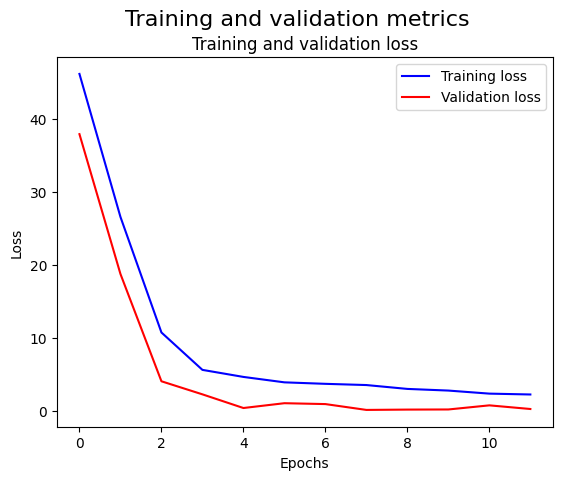

In [31]:
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))



plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Training and validation metrics', fontsize=16)
plt.show()

In [14]:
print(test_score[0])
print(score_dist_list[0])

[0.         0.00696864 0.01393728 0.03135889 0.09407666 0.21602787
 0.24041812 0.19860627 0.13937283 0.05923345]
[0.00082279 0.00070856 0.00232894 0.01091851 0.10275402 0.17975947
 0.2120024  0.22104469 0.14189786 0.12776278]
